In [1]:
#|default_exp init

# Initialization

In [2]:
#|export
import pickle
import gzip
import math
import sys
import gc
import os
import time
import traceback
import shutil
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy

from torch import nn
import torchvision.transforms.functional as TF
from torch import nn, tensor, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import * 
from miniai.conv import * 
from miniai.learner import * 
from miniai.activations import * 

In [3]:
from IPython.core.debugger import set_trace
import fastcore.all as fc
from fastcore.test import test_close
plt.style.use('fast')
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

import logging; logging.disable(logging.WARNING)
set_seed(42)

In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

  0%|          | 0/2 [00:00<?, ?it/s]

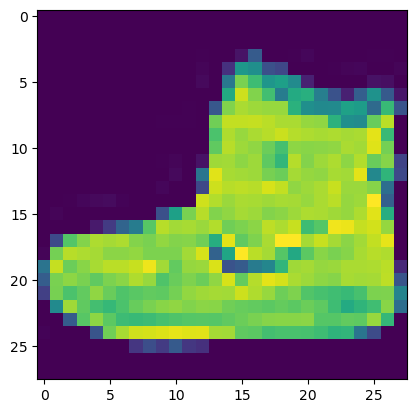

In [5]:
plt.imshow(dsd['train'][0][xl])

In [6]:
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [7]:
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [23]:
def get_model():
    return nn.Sequential(
        conv(1, 8), conv(8, 16), conv(16, 32), 
        conv(32, 64), conv(64,10, act=False),
        nn.Flatten()
    ).to(device)

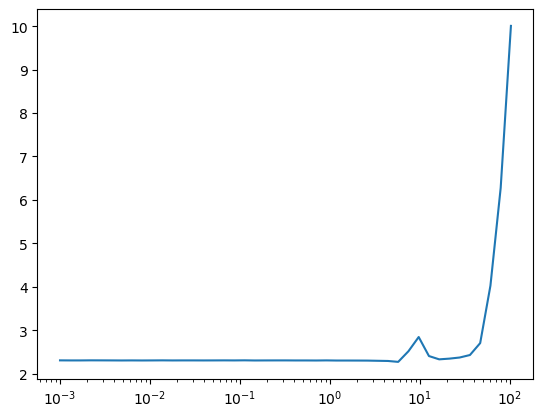

In [24]:
learn = Learner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()])
learn.lr_find(start_lr=1e-3)

accuracy,loss,epoch,train
0.124,2.291,0,train
0.100,2.303,0,valid


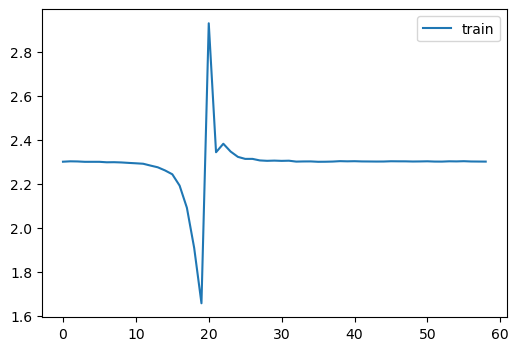

In [25]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.3, cbs=cbs)
learn.fit()

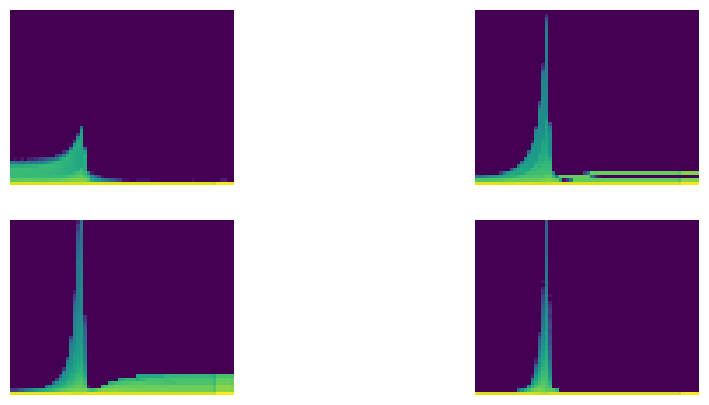

In [26]:
astats.color_dim()

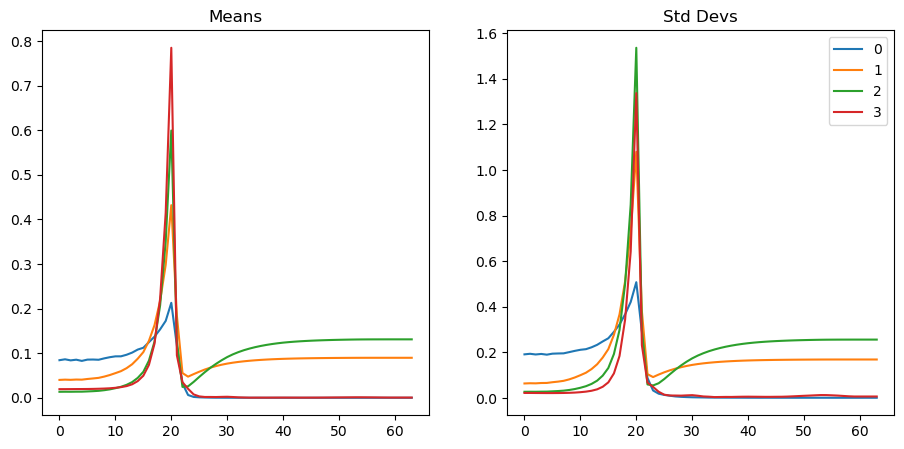

In [27]:
astats.plot_stats()

In [28]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''
    
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')    
    
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Variance and Covariance

### Variance

Defined as the average square deviation from the mean of a dataset

$$\text{Var}(X) = E\left[(X-E[X])^2\right] = E[X]^2 - E[X^2]$$

In [14]:
x = torch.randn(200)

In [14]:
x.mean()

tensor(-0.00)

In [15]:
((x-x.mean())**2).mean()

tensor(0.98)

### Covariance

Defined as the average of the products of the components from the mean:

$$\text{Cov}(X, Y)= E\left[(X-E[X](Y-E[Y]\right]$$

So $$\text{Var}(X) = \text{Cov}(X, X)$$

### Linearity of expectation

If $X, Y$ are i.i.d, then 

$$E[X+Y] = E[X] + E[Y]$$

### Independence

$$E[XY] = E[X]E[Y]$$

Since X,Y are i.i.d, then X^2, Y^2 are so as well.
$$Cov(X, Y) = E\left[(X-E[X](Y-E[Y]\right] $$
$$= E\left[XY -E[X]Y - E[Y]X + E[X]E[Y]\right] $$
$$= E[XY] - E[X]E[Y]$$
$$= 0$$

### Variance of the product

Given $X, Y$ iid with means $\mu_x, \mu_y$ and variances $\sigma_x^2,\sigma_y^2$ then the variance of their product is given by

$$Var(XY) = E[X^2Y^2] - E[X]^2E[Y]^2 $$
$$= E[X^2]E[Y^2] - E[X]^2E[Y]^2 $$

By definition:

$$\sigma_x^2 = E[X^2] - \mu_x^2$$

Hence:

$$Var(XY) = (\sigma_x^2 + \mu_x^2)(\sigma_y^2 + \mu_y^2) - \mu_x^2\mu_y^2$$

If $X,Y$ have mean 0 and std 1. Then 

$$Var(XY) = 1$$

In [16]:
y = torch.randn(200)

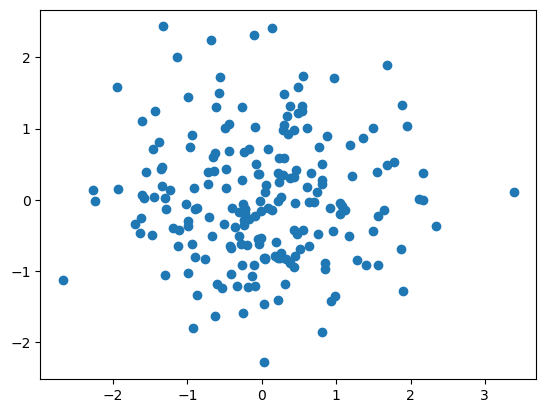

In [17]:
plt.scatter(x, y)

In [18]:
(x-y).mean()

tensor(-0.03)

In [19]:
((x-x.mean())*(y-y.mean())).mean()

tensor(-0.00)

## Initializing weights

In [20]:
x = torch.randn(200,100)
for i in range(50): x = x @torch.randn(100, 100)

In [21]:
x.mean(), x.std()

(tensor(nan), tensor(nan))

## Glorot init

Ensure that we're keeping the mean at 0 and stddev at 1.

In [15]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 1/math.sqrt(100))

In [16]:
x.mean(), x.std()

(tensor(0.01), tensor(1.26))

In [17]:
mean, sqr = 0., 0.
n = 100
n_out = 10000
for i in range(n):
    x = torch.randn(100)
    a = torch.randn(n_out, 100)
    y = a@x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()
mean/n, sqr/n

(-0.008717299932613968, 101.11804725646972)

In [18]:
#| export
init_layers = (
    nn.Conv1d, 
    nn.Conv2d, 
    nn.Conv3d, 
    nn.ConvTranspose1d, 
    nn.ConvTranspose2d, 
    nn.ConvTranspose3d, 
    nn.Linear)

In [29]:
def init_weights(m):
    if isinstance(m, init_layers): init.kaiming_normal_(m.weight)

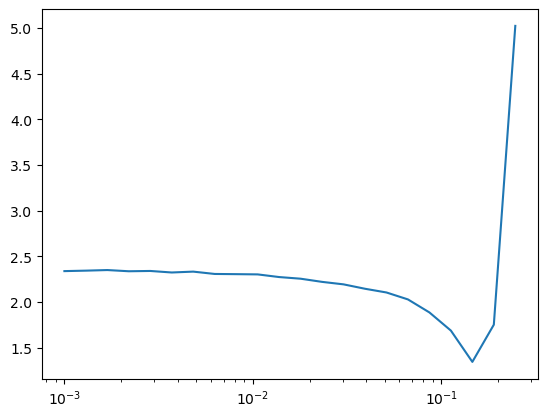

In [33]:
model = get_model()
model.apply(init_weights)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.6, cbs=[DeviceCB()])
learn.lr_find(start_lr=1e-3)

accuracy,loss,epoch,train
0.359,1.908,0,train
0.674,0.871,0,valid
0.767,0.609,1,train
0.806,0.521,1,valid
0.825,0.468,2,train
0.826,0.472,2,valid


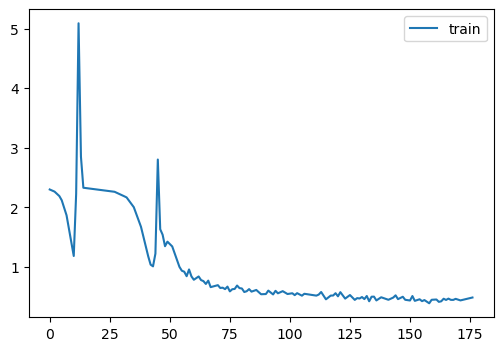

In [34]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats()
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=[DeviceCB(), metrics, astats, ProgressCB(plot=True)])
learn.fit(3)

In [ ]:
astats.color_dim()

In [ ]:
astats.dead_chart()

In [ ]:
astats.plot_stats()

## Batch Transforms 

In [ ]:
#| export
import fastcore.all as fc

class BatchTfmCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()
    def before_batch(self, learn: Learner): 
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [ ]:
def _norm(b): 
    x, y = b
    return (x-x.mean())/x.std(), y

In [21]:
batch_norm = BatchTfmCB(_norm)
astats = ActivationStats(fc.risinstance(nn.ReLU))
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=[DeviceCB(), batch_norm, metrics, astats, ProgressCB(plot=True)])
learn.fit(3)

NameError: name 'BatchTfmCB' is not defined

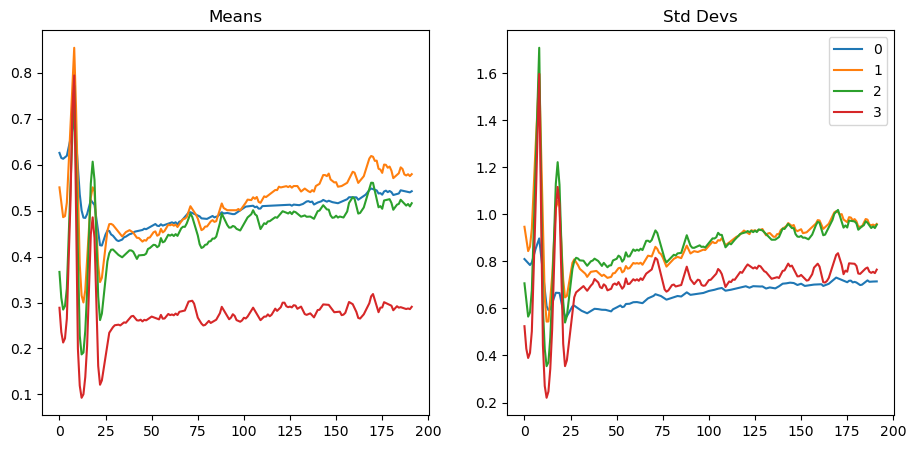

In [35]:
astats.plot_stats()

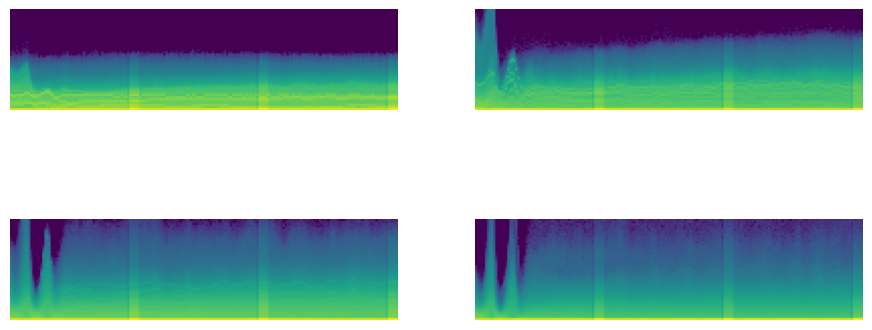

In [36]:
astats.color_dim() 

### Data normalization

We can normalize during dataloading

In [37]:
@inplace
def transformi(b): b[xl] = [(t-t.mean())/t.std() for t in (TF.to_tensor(o) for o in b[xl])]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb, yb = next(iter(dls.train))
xb.mean(), xb.std()


(tensor(    -0.00), tensor(1.00))

In [38]:
#| export 
class GeneralReLU(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x-=self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [39]:
#| export
def plot_func(f, start=-5, end=5, steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)

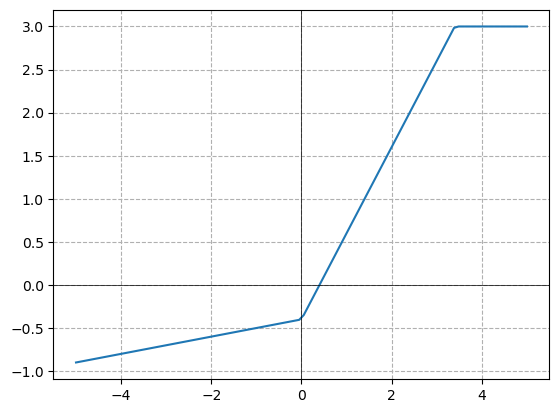

In [40]:
plot_func(GeneralReLU(leak=0.1, sub=0.4, maxv=3))

In [41]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [42]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs) -1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None), 
        nn.Flatten()).to(device)

In [43]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, init_layers): init.kaiming_normal_(m.weight, a=leaky)

In [44]:
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

accuracy,loss,epoch,train
0.744,0.722,0,train
0.831,0.459,0,eval
0.857,0.393,1,train
0.851,0.406,1,eval
0.873,0.347,2,train
0.861,0.371,2,eval


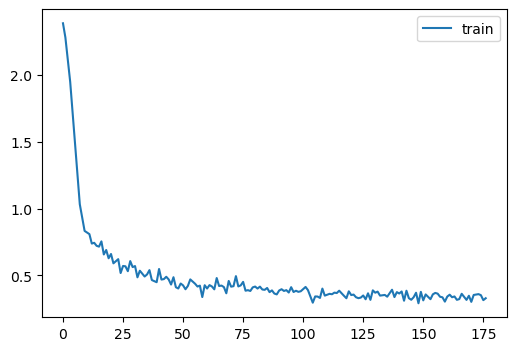

In [45]:
set_seed(42)
learn = MomentumLearner(get_model(act_gr).apply(iw), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(3)

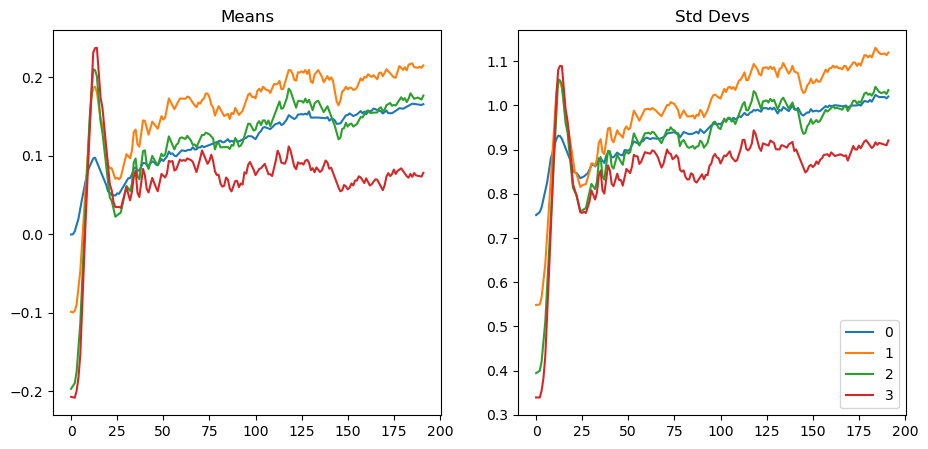

In [46]:
astats.plot_stats()

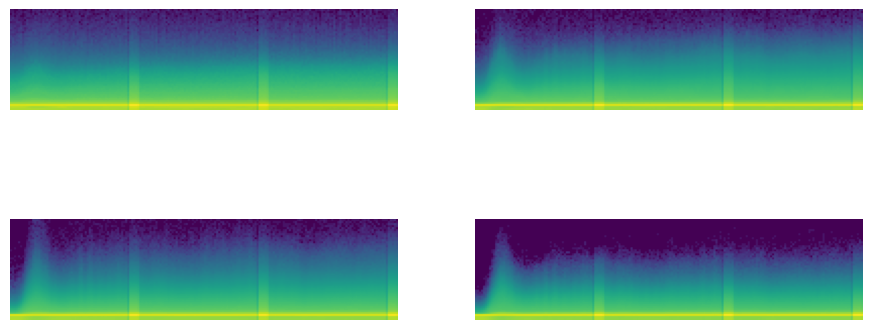

In [47]:
astats.color_dim()

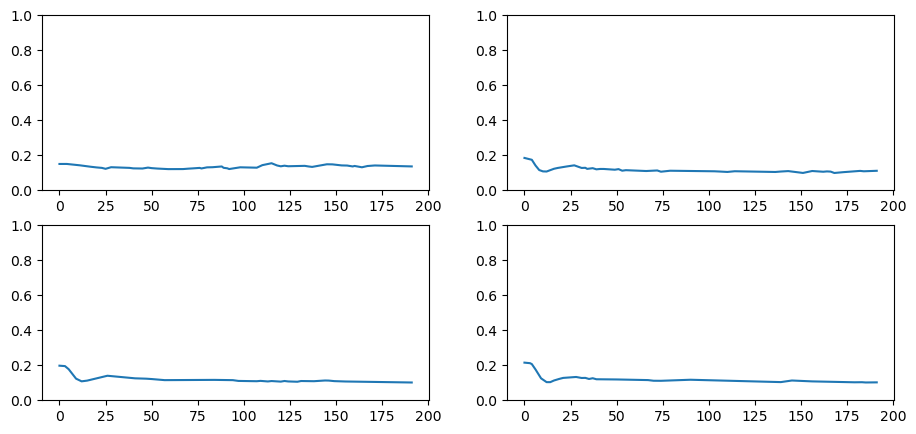

In [48]:
astats.dead_chart()

## LSUV

Iteratively fix the mean and std by empirically computing the forward pass and adjusting the stats until we're satisfied

In [49]:
#|export
@hook
def lsuv_stats(hook, mod, inp, out):
    acts = to_cpu(out)
    hook.mean = acts.mean()
    hook.std = acts.std()

In [50]:
#|export
def lsuv_init(model, m, m_in, xb, verbose=False):
    lsuv = lsuv_stats(m) # only hook into the selected layers
    with torch.no_grad():  

        while model(xb) is not None and (abs(lsuv.std-1) > 1e-3 or abs(lsuv.mean) > 1e-3):                 
            m_in.bias -= lsuv.mean
            m_in.weight.data /= lsuv.std   
            if verbose:
                print(f"Init: mean {lsuv.mean} std {lsuv.std}")
    lsuv.remove()

In [51]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralReLU)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [52]:
for ms in zip(relus, convs): print(ms)

(GeneralReLU(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [53]:
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(device))

In [54]:
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

accuracy,loss,epoch,train
0.541,1.297,0,train
0.770,0.665,0,eval
0.829,0.461,1,train
0.845,0.412,1,eval
0.871,0.350,2,train
0.867,0.355,2,eval


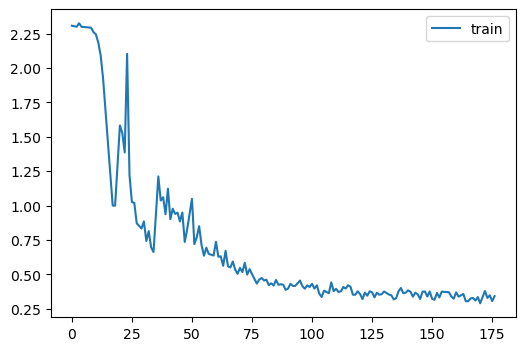

In [55]:
set_seed(42)

learn = MomentumLearner(get_model(act_gr), dls, F.cross_entropy, lr=0.25, cbs=cbs)
learn.fit(3)

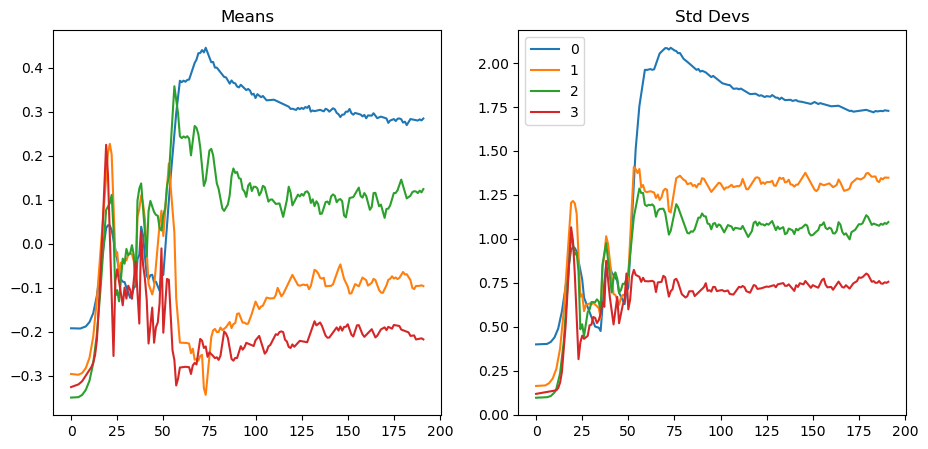

In [56]:
astats.plot_stats()

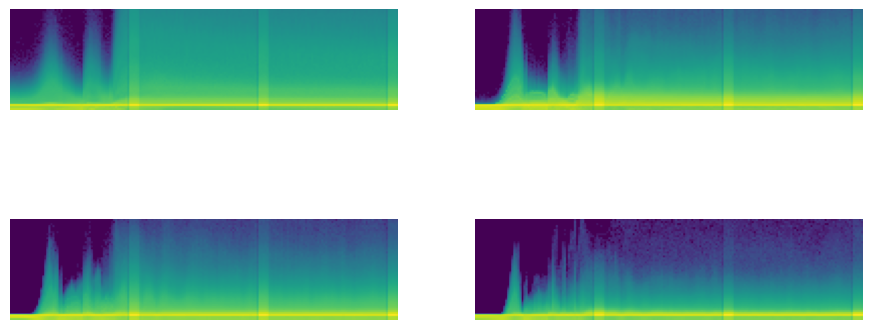

In [57]:
astats.color_dim()

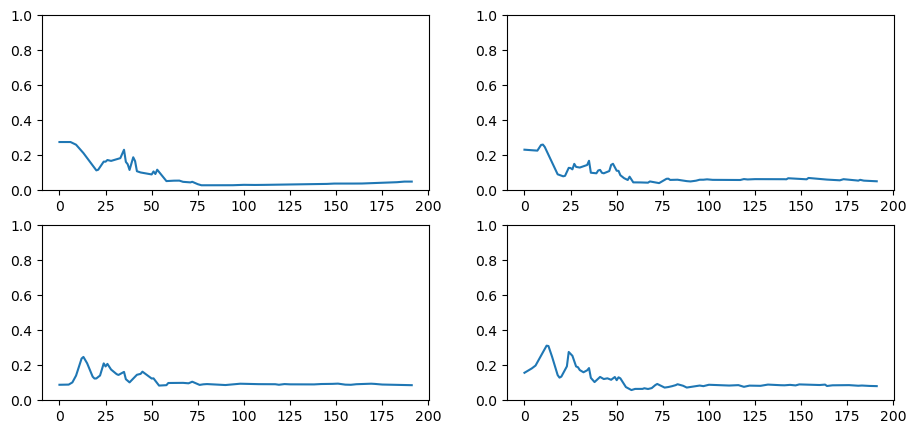

In [58]:
astats.dead_chart()

In [111]:
#| export
from fastcore.all import risinstance

act_layers = (    
    nn.ReLU,
    nn.ReLU6,
    GeneralReLU,
)

class LSUVInitCB(Callback):
    def __init__(self, 
                 layers=risinstance(init_layers), 
                 acts=risinstance(act_layers),
                 verbose=False):
        self.layer_filter = layers
        self.act_filter = acts
        self.verbose = verbose
        
    def before_fit(self, learn: Learner):
        layers = [o for o in learn.model.modules() if self.layer_filter(o)]
        activations = [o for o in learn.model.modules() if self.act_filter(o)]
        xb, _ = next(iter(learn.dls.train))
        xb = xb.to(device)
        
        for layer, act in zip(layers, activations):
            lsuv_init(learn.model, act, layer, xb, verbose=self.verbose)

            

accuracy,loss,epoch,train
0.778,0.626,0,train
0.841,0.428,0,eval
0.865,0.366,1,train
0.857,0.390,1,eval
0.880,0.324,2,train
0.869,0.360,2,eval


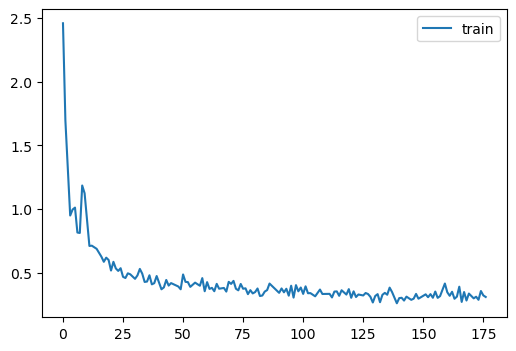

In [60]:
set_seed(42)
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), LSUVInitCB(acts=fc.risinstance(GeneralReLU)), ProgressCB(plot=True), metrics, astats]
learn = MomentumLearner(get_model(act_gr), dls, F.cross_entropy, lr=0.25, cbs=[DeviceCB(), LSUVInitCB(), astats, ProgressCB(plot=True), metrics])
learn.fit(3)

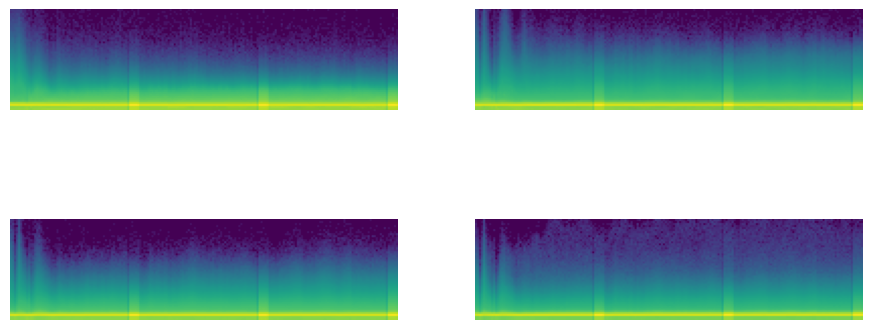

In [61]:
astats.color_dim()

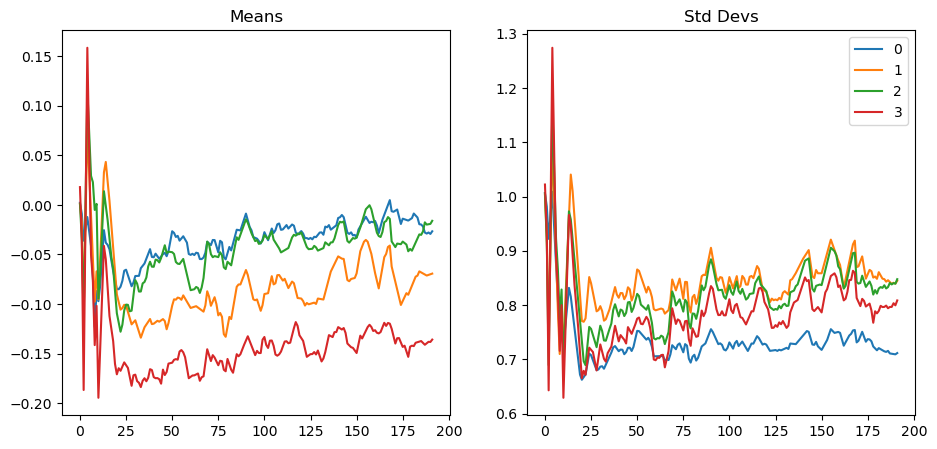

In [62]:
astats.plot_stats()

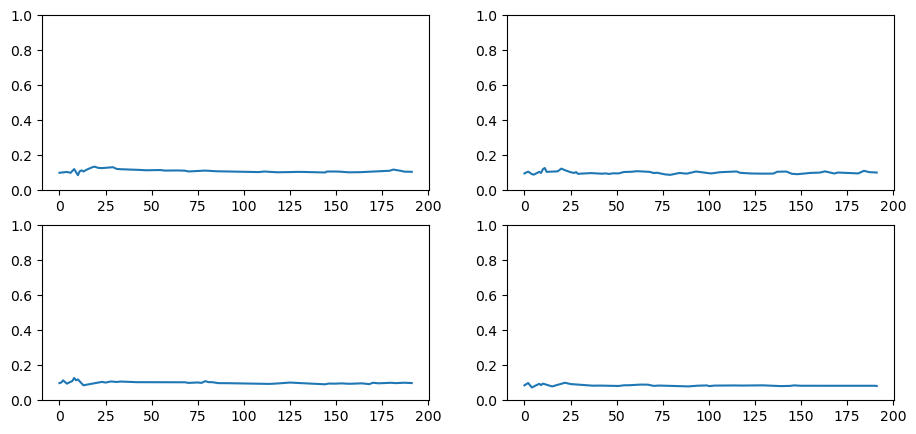

In [63]:
astats.dead_chart()

## LayerNorm

In [64]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x-m)/((v+self.eps).sqrt())
        return x*self.mult + self.add

In [65]:
#| export
batch_layers = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

def conv(ni, nf, ks=3, stride=3, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, batch_layers)
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [66]:
#| export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) 
              for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=False, bias=True),
        nn.Flatten()).to(device)

accuracy,loss,epoch,train
0.745,0.722,0,train
0.826,0.480,0,eval
0.851,0.411,1,train
0.849,0.418,1,eval
0.868,0.364,2,train
0.867,0.370,2,eval


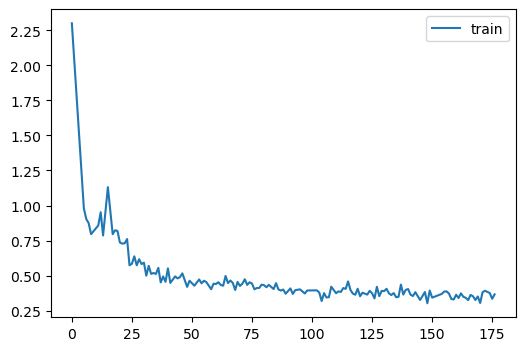

In [67]:
set_seed(42)
iw = partial(init_weights, leaky=0.1)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
astats = ActivationStats(fc.risinstance(GeneralReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), LSUVInitCB(verbose=True), ProgressCB(plot=True), astats, metrics]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), ProgressCB(plot=True), metrics, astats])
learn.fit(3)

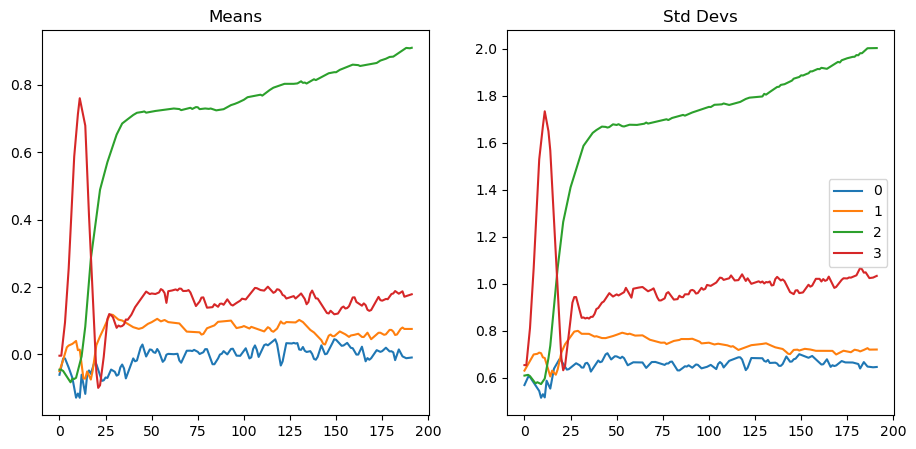

In [68]:
astats.plot_stats()

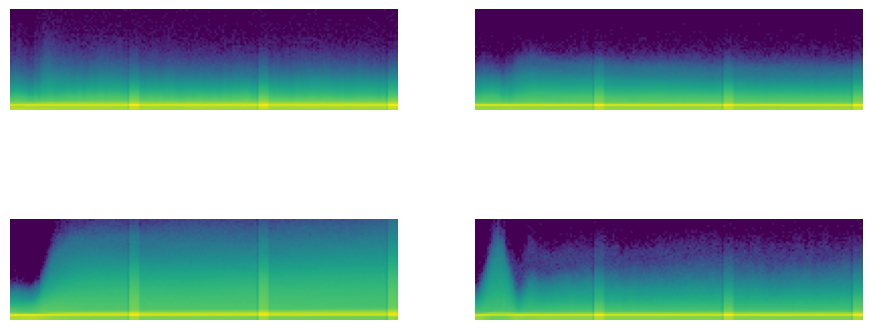

In [69]:
astats.color_dim()

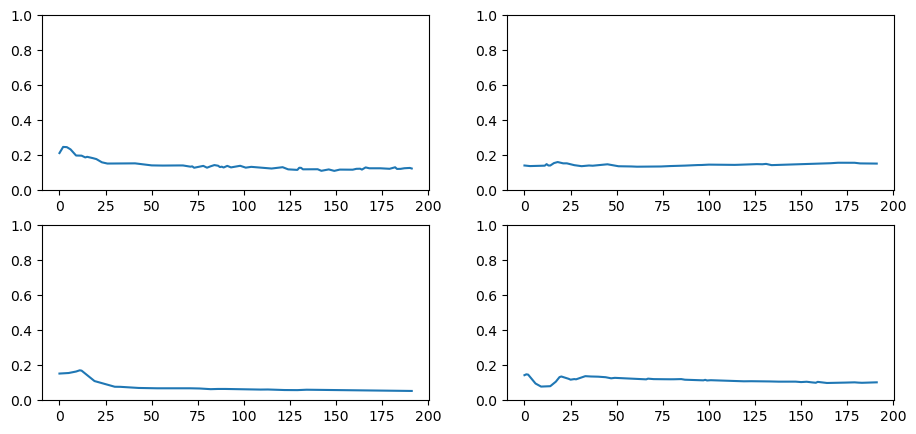

In [70]:
astats.dead_chart()

## BatchNorm
![Various norms](../images/norms.png)

In [75]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars',  torch.ones (1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
    
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var ((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): 
                m, v = self.update_stats(x)
        else: 
            m, v = self.means, self.vars
            
        x =  (x-m)/(v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.763,0.656,0,train
0.769,0.615,0,eval
0.849,0.411,1,train
0.841,0.436,1,eval
0.863,0.369,2,train
0.842,0.414,2,eval
0.874,0.343,3,train
0.839,0.448,3,eval
0.880,0.324,4,train
0.829,0.465,4,eval


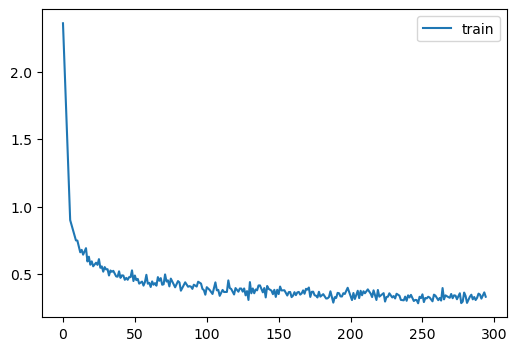

In [79]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
cbs = [DeviceCB(device=torch.device('cpu')), ProgressCB(plot=True), astats, metrics]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(5)


# Getting closer to 90%

In [86]:
dls = DataLoaders.from_dd(tds, batch_size=256, num_workers=4)

accuracy,loss,epoch,train
0.829,0.467,0,train
0.856,0.393,0,eval
0.874,0.340,1,train
0.860,0.382,1,eval
0.883,0.311,2,train
0.870,0.346,2,eval


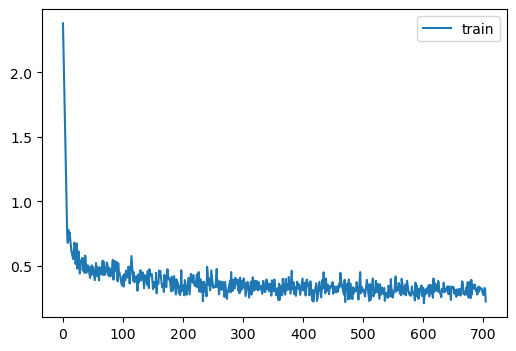

In [87]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
astats = ActivationStats()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), ProgressCB(plot=True), astats, metrics]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.3, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.901,0.266,0,train
0.886,0.314,0,eval
0.903,0.258,1,train
0.889,0.313,1,eval


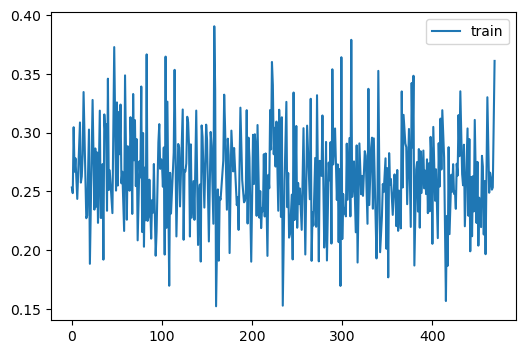

In [88]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(2)

accuracy,loss,epoch,train
0.910,0.242,0,train
0.890,0.308,0,eval
0.910,0.237,1,train
0.891,0.307,1,eval


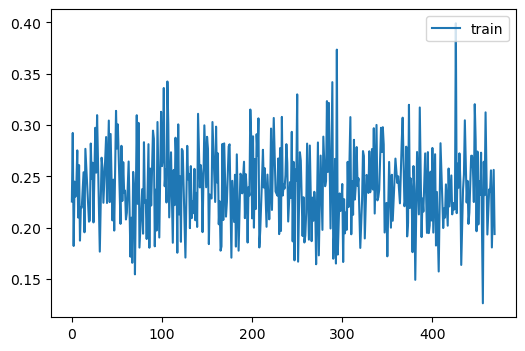

In [89]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

# Config Class

In [ ]:
#| export
from pydantic.dataclasses import dataclass
from dataclasses import asdict
from functools import partial

@dataclass
class BaseConfig():
    ds: str
    arch: str
    project: str
    epochs: int = 5
    lr:float = 3e-3
    betas= (0.9, 0.95)
    batch_size: int = 64
    bias:bool = True
    model_path:str = 'models'
    save: bool = False
    max_to_keep: int = 1
    attn_dropout: float = 0.0
    dropout: float = 0.01
    
    leak = 0.1
    act = partial(GeneralReLU, leak=leak, sub=0.4)

# Export

In [2]:
import nbdev; nbdev.nbdev_export()